# Embedding Exploration — Token to Sentence Level
This notebook walks through a user-centric progression of analyzing transformer embeddings, from token-level geometry to sentence-level similarity and retrieval diagnostics.

In [61]:
import torch
from raglens.embeddings import EmbeddingModel
from raglens.visualization import (
    plot_token_geometry, plot_chunk_geometry, compare_pooling_methods,
    semantic_similarity_matrix, embedding_distribution_stats, layerwise_token_drift,
    chunking_length, chunking_sanity
)
from raglens.retrieval import ChunkRetriever, compare_retrieval_pooling
from raglens.explainer import generate_plot_explanation, get_base64_encoded_plot

## 1. Token-Level

### 1.1 Embedding Geometry
Understand how tokens are distributed in vector space using PCA or UMAP

In [51]:
model = EmbeddingModel()
tokenizer = model.tokenizer
text = "The authors show that it is possible to train a transformer from scratch to perform in-context learning of linear functions."
token_embeddings, tokens, _ = model.embed_text(text)

Model 'sentence-transformers/all-MiniLM-L6-v2' supports CLS token pooling.


c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

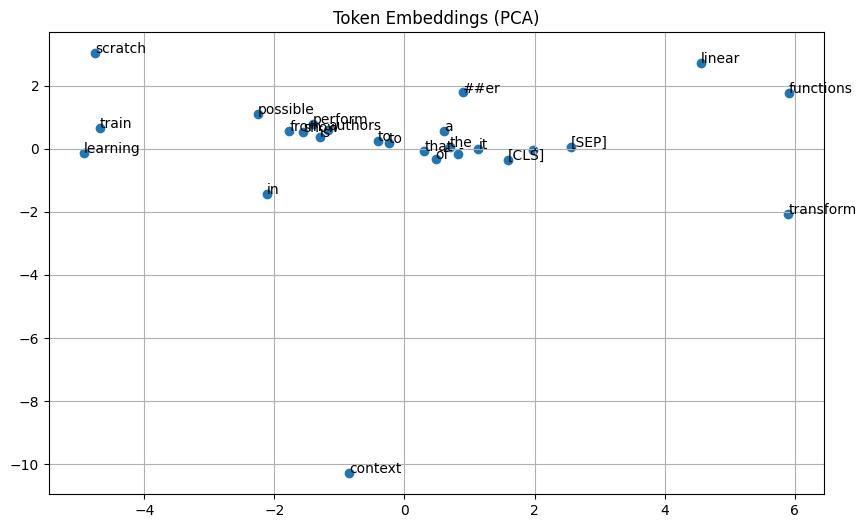

In [53]:
fig = plot_token_geometry(
            token_embeddings, tokens, method="pca", 
            generate_explanation=False
        )

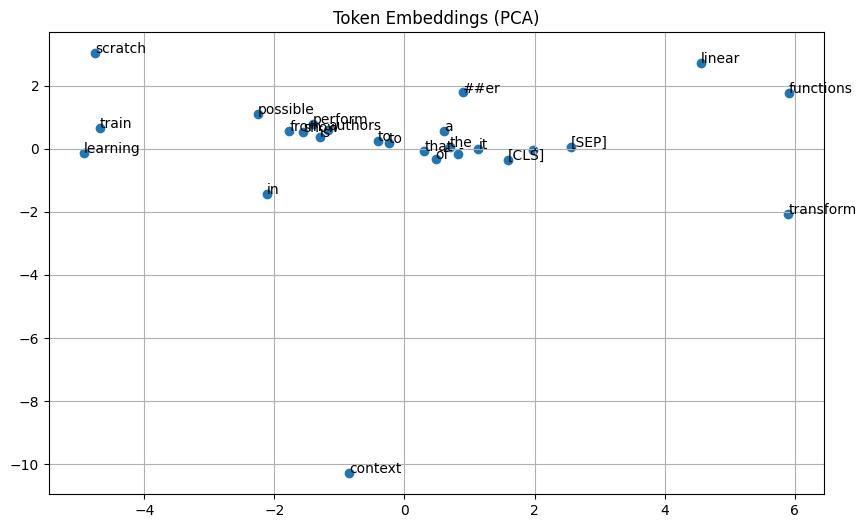

In [ ]:
fig, explanation = plot_token_geometry(
            token_embeddings, tokens, method="pca", 
            generate_explanation=True,
            language="English", # Language for explanation, e.g., "English", "Spanish", etc., defaults to "English"
        )

In [47]:
print(explanation)

Below is a step-by-step interpretation of what you’re seeing in the PCA plot of your 25 tokens, together with some take-aways and recommendations.

1. What the plot shows  
   • Every point is one of the input tokens, projected into 2D by PCA on their  hidden-state embeddings.  
   • The axes (PC1, PC2) are the two directions of greatest variance in that mini­batch of embeddings.  
   • Spatial proximity implies that two tokens have similar embedding vectors (i.e. the model “thinks” they’re used in similar contexts).  

2. Key patterns or insights  
   • Function words cluster around the origin:  
     – “the”, “a”, “to”, “of”, “it”, “is”, “in”, “that”, “.”, “-” all lie in a tight cloud near (0,0).  
     – This reflects the fact that these high­frequency words tend not to carry strong topic signal and share similar distributional profiles.  
   • Content words fan out along PC1/PC2:  
     – “transform” and its subword “##er” sit on the far right, indicating a shared morphological/sem

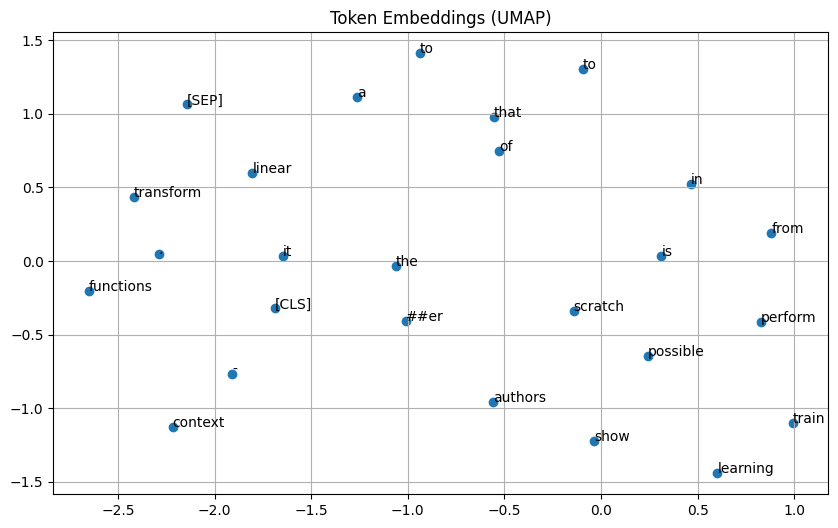

In [54]:
fig = plot_token_geometry(
            token_embeddings, tokens, method="umap", 
            generate_explanation=False
        )

### 1.2 Layer-wise Token Drift
Visualize how selected tokens change across transformer layers.

In [55]:
print(tokens)

['[CLS]', 'the', 'authors', 'show', 'that', 'it', 'is', 'possible', 'to', 'train', 'a', 'transform', '##er', 'from', 'scratch', 'to', 'perform', 'in', '-', 'context', 'learning', 'of', 'linear', 'functions', '.', '[SEP]']


c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


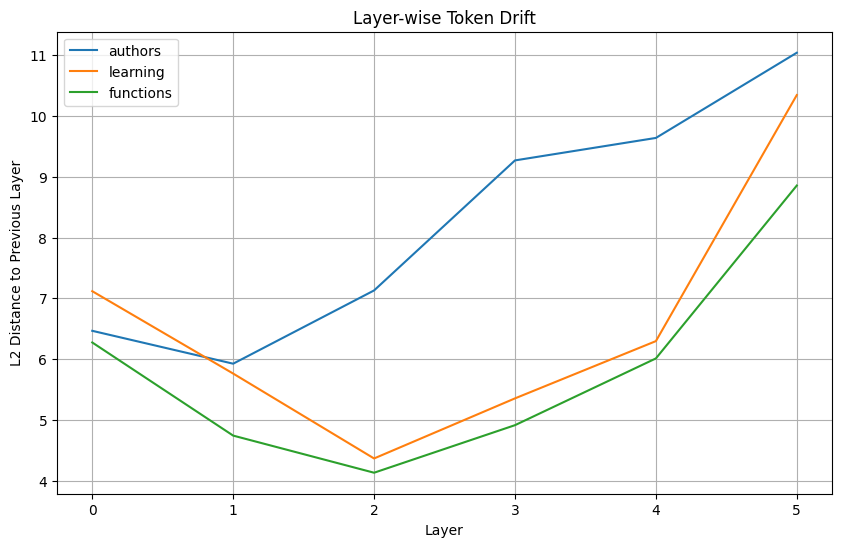

Here’s a step-by-step read-out of what you’re seeing and what it might mean for your model:

1. What the plot shows  
   • Along the x-axis are transformer layers 0→5.  
   • The y-axis is the L₂ distance (“drift”) between a token’s vector in the current layer vs. the previous layer.  
   • You are tracing three content words—“authors,” “learning” and “functions”—to see how much their embeddings move at each hop through the network.

2. Key patterns or insights  
   • Initial moderate movement (Layer 0→1): all three tokens shift by roughly 5–7 units. This is the first contextualization step from raw input embeddings.  
   • Early dip (Layer 1→2): drift drops to ~4–5 units for all tokens—often seen when the model is “settling in” to the broad syntactic frame before applying more fine-grained refinements.  
   • Ramp-up in deeper layers (Layers 2→5): drift progressively increases, peaking at the very last layer.  
     – “authors” shows the highest overall drift (11.1 at the final layer)

In [56]:
fig, explanation =layerwise_token_drift(text, model, 
                                        token_strs=["authors","learning","functions"], 
                                        generate_explanation=True
                                        )
print(explanation)

## 2. Sentence-Level

### 2.1 Compare Pooling Methods
Explore the similarity between CLS, Mean, and Max pooling strategies.

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


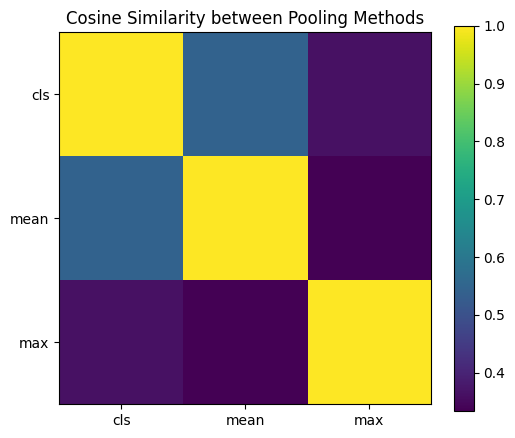

In [57]:
fig = compare_pooling_methods(model, text, generate_explanation=False)

### 2.2 Sentence-Level Semantic Similarity
Compare sentence similarities using pooled embeddings across strategies.

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


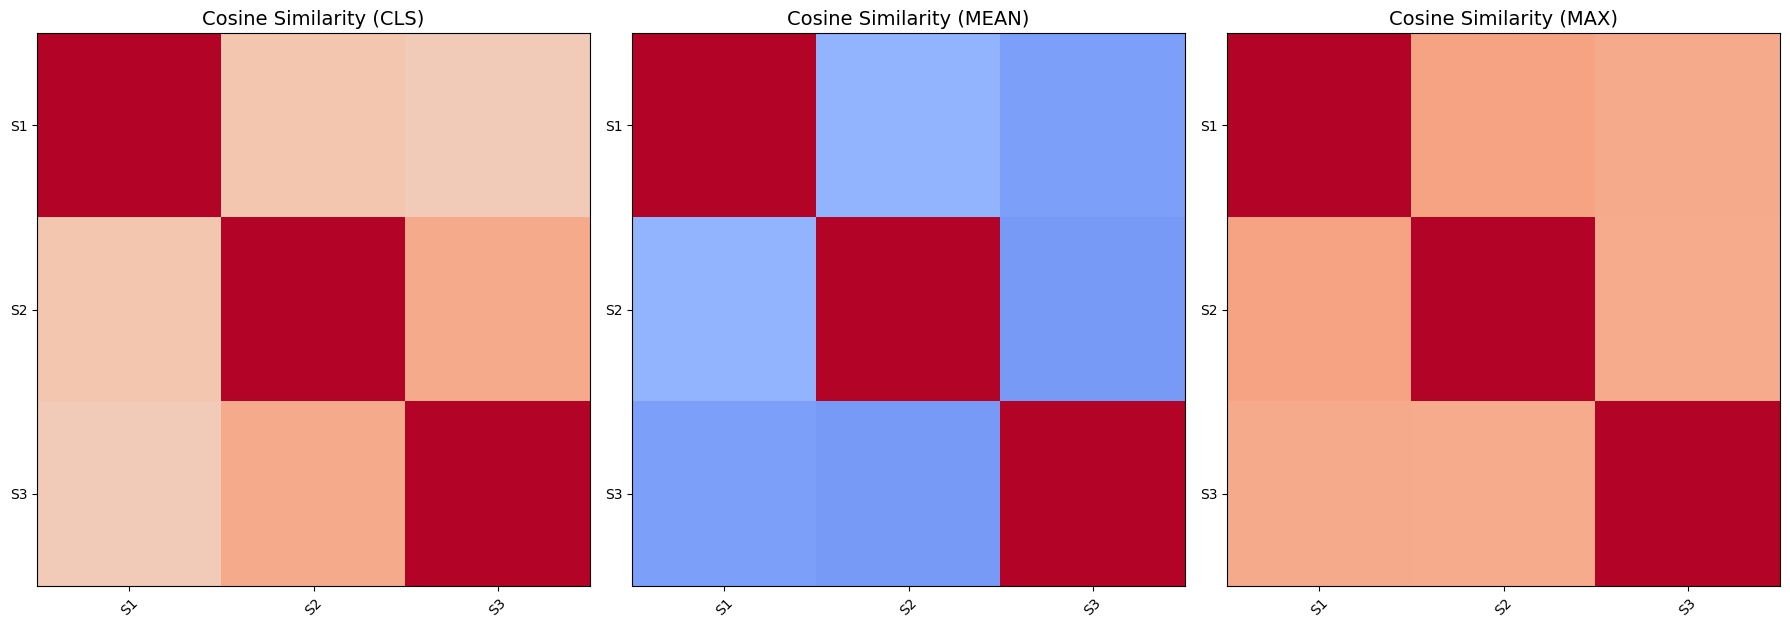

In [58]:
sentences = [
    "Transformers learn to map sequences.",
    "Attention helps models focus.",
    "Training from scratch is expensive."
]
fig = semantic_similarity_matrix(sentences, model, generate_explanation=False)

### 2.3 Embedding Distribution Statistics
Plot L2 norms and PCA explained variance of token embeddings.

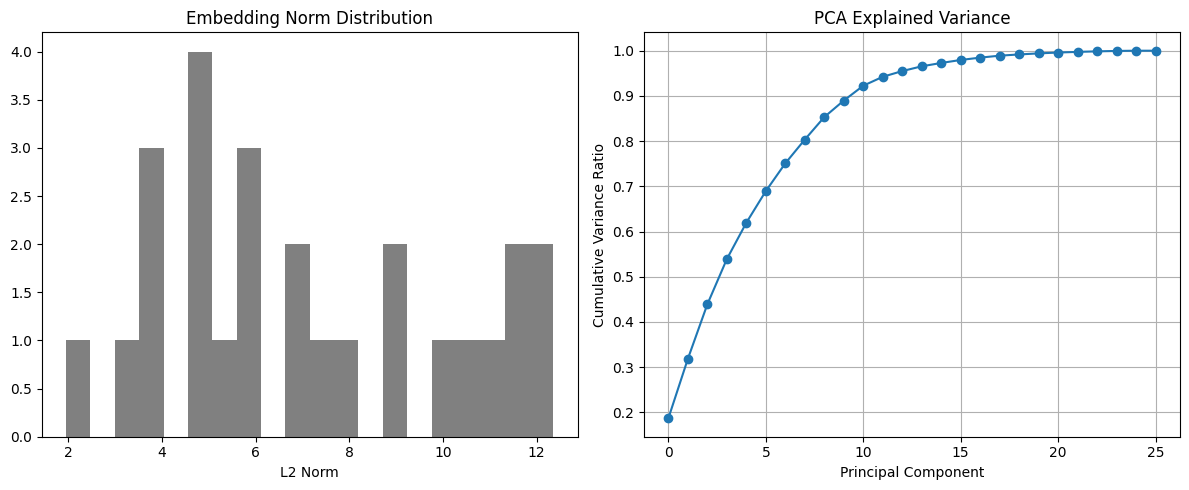

Here’s a step‐by‐step walkthrough of what you’re seeing, what it suggests about your 26×384 embedding matrix, and some practical take‐aways:

1. What the plots show  
   • Left: A histogram of the L₂‐norm of each of your 26 token vectors.  
     – Norms range roughly from ~2 up to ~12, with an average around 7.16.  
     – A few very small‐norm points (~2–3) and a few large‐norm “outliers” (~10–12) sit at the tails.  
   • Right: The cumulative explained‐variance curve from a PCA of those 26 vectors (projected into up to 25 nonzero components).  
     – The first principal component alone explains ~19% of the total variance;  
     – By the 5th PC you’re at ~69%; by PC 10 you’re at ~89–92%; by PC 15 you’re ~97–98%.  
     – Beyond ~20 PCs you asymptote at ~100% (all remaining small dimensions combined).

2. Key patterns and insights  
   • Norm variability: There is a fairly wide spread in vector lengths. This implies some tokens are “much stronger” (higher magnitude) than others.  
  

In [59]:
fig, explanation = embedding_distribution_stats(token_embeddings, generate_explanation=True)
print(explanation)

## 3. Chunks level

### 3.1 Sanity Check
Visualize the token lengths of document chunks.

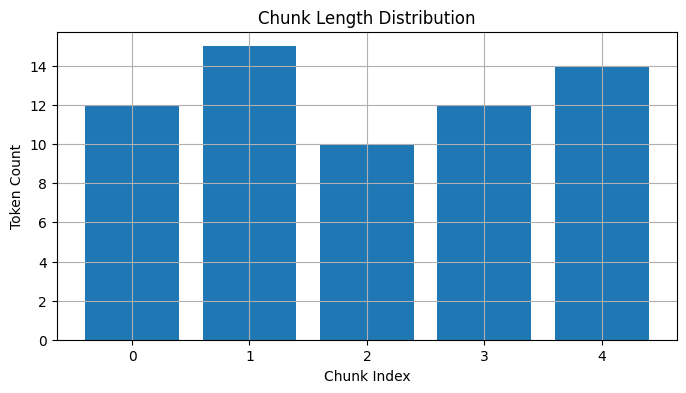

In [60]:
chunks = [
    "Transformers can be trained from scratch for various tasks.",
    "In-context learning allows models to generalize on the fly.",
    "Linear functions are often studied in mathematics.",
    "The authors describe a novel approach to training models.",
    "Tokenization is a crucial step in NLP pipelines."
]
fig = chunking_length(chunks, tokenizer, generate_explanation=False)

In [62]:
chunking_sanity(chunks, tokenizer)


🧩 Chunking Diagnostics

--- Chunk 1 ---
Tokens: ['transformers', 'can', 'be', 'trained', 'from', 'scratch', 'for', 'various', 'tasks', '.']
Ends cleanly: ✅
Token count: 10

--- Chunk 2 ---
Tokens: ['in', '-', 'context', 'learning', 'allows', 'models', 'to', 'general', '##ize', 'on', 'the', 'fly', '.']
Ends cleanly: ✅
Token count: 13

--- Chunk 3 ---
Tokens: ['linear', 'functions', 'are', 'often', 'studied', 'in', 'mathematics', '.']
Ends cleanly: ✅
Token count: 8

--- Chunk 4 ---
Tokens: ['the', 'authors', 'describe', 'a', 'novel', 'approach', 'to', 'training', 'models', '.']
Ends cleanly: ✅
Token count: 10

--- Chunk 5 ---
Tokens: ['token', '##ization', 'is', 'a', 'crucial', 'step', 'in', 'nl', '##p', 'pipeline', '##s', '.']
Ends cleanly: ✅
Token count: 12

🔁 Overlap Check
Chunk 4 overlaps with 3: ['a']



### 3.2 Visualize Chunk Embeddings with Pooling
Show chunk embeddings in 2D space by pooling strategy.

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


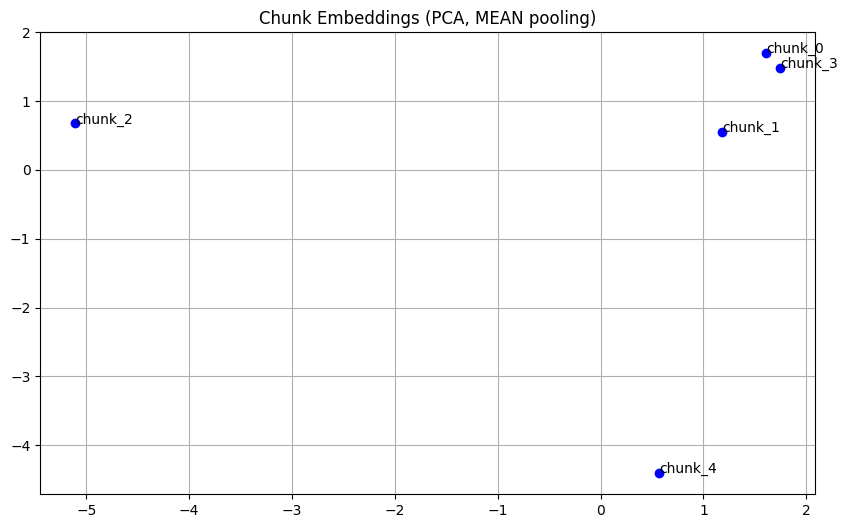

Here’s a detailed walk-through of what this 2D PCA scatterplot of your five chunks (mean-pooled embeddings) is telling us, and what you might take away from it.

1. What the plot shows  
   • Each dot (chunk_0 through chunk_4) is one of your text chunks, projected from its high-dimensional embedding down to two principal components.  
   • Distances between points roughly reflect semantic similarity: close points were judged “alike” by the embedding space, far-apart points “dissimilar.”  
   • Axes themselves (PC1 and PC2) are linear combinations of embedding dimensions and have no direct linguistic meaning, but their relative spread shows where most variance lies.

2. Key patterns or insights  
   • Tight “training/model” cluster in the upper right  
     – chunk_0 (“Transformers can be trained…”) and chunk_3 (“The authors describe a novel approach to training…”) almost overlap.  
     – chunk_1 (“In-context learning…”) sits close by.  
     ⇒ The model clearly sees these three as sem

In [63]:
fig, explanation = plot_chunk_geometry(chunks, model, strategy="mean", method="pca", generate_explanation=True)
print(explanation)

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


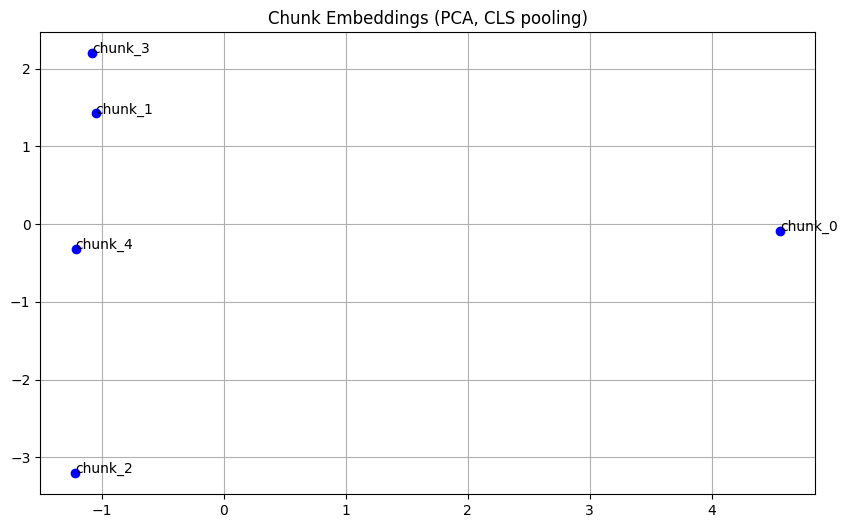

In [64]:
fig = plot_chunk_geometry(chunks, model, strategy="cls", method="pca", generate_explanation=False)

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


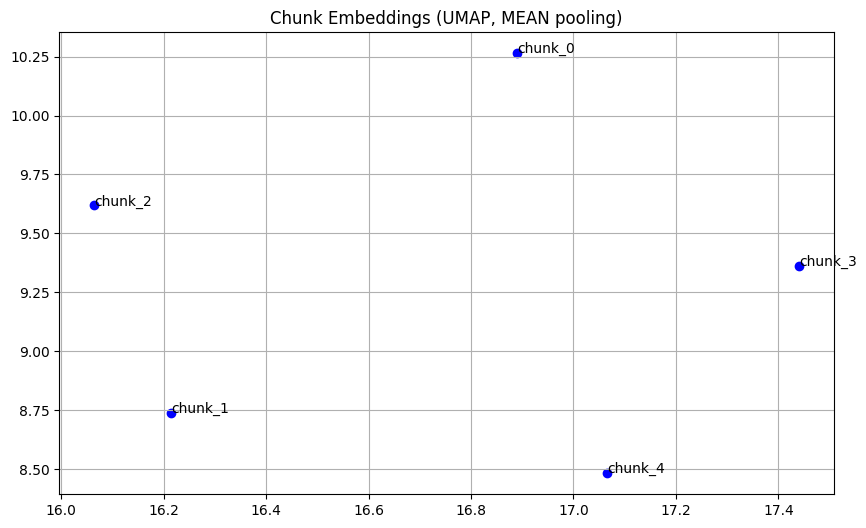

In [65]:
fig = plot_chunk_geometry(chunks, model, strategy="mean", method="umap", generate_explanation=False)

## Retrieval diagnostic

In [66]:
# Initialize retriever and add chunks once
retriever = ChunkRetriever(model)
retriever.add_chunks(chunks)

c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [67]:
query = "How can transformers learn linear functions from scratch?"

In [68]:
compare_retrieval_pooling(retriever, query)


🔍 Retrieval results for query: 'How can transformers learn linear functions from scratch?'

--- Pooling Strategy: CLS ---
[0.461] Transformers can be trained from scratch for various tasks.
[0.219] Linear functions are often studied in mathematics.
[0.206] In-context learning allows models to generalize on the fly.

--- Pooling Strategy: MEAN ---
[0.720] Transformers can be trained from scratch for various tasks.
[0.476] Linear functions are often studied in mathematics.
[0.330] In-context learning allows models to generalize on the fly.

--- Pooling Strategy: MAX ---
[0.292] Transformers can be trained from scratch for various tasks.
[0.223] Linear functions are often studied in mathematics.
[0.153] In-context learning allows models to generalize on the fly.



c:\Users\killg\PythonApps\raglens\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


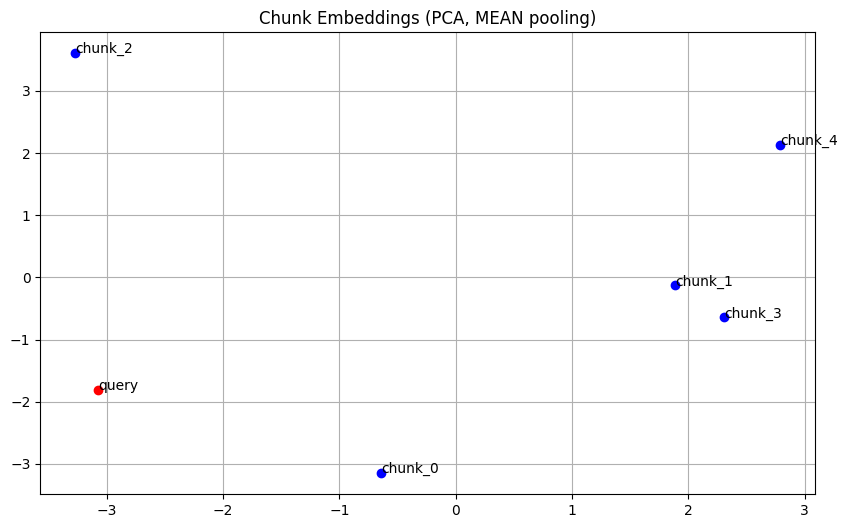

Here’s a step-by-step interpretation of what you’re seeing and what it means for your embedding-and-retrieval pipeline.

1. What the plot shows  
   • Each blue point (chunk_0 … chunk_4) is the MEAN-pooled embedding of one of your five text chunks, projected down to 2D by PCA.  
   • The red point is your query embedding (“How can transformers learn linear functions from scratch?”), likewise mean-pooled and PCA-projected.  
   • Spatial proximity in this plot roughly corresponds to semantic similarity in the original embedding space (modulo the distortions introduced by PCA).

2. Key patterns or insights  
   – chunk_0 (“Transformers can be trained from scratch…”) lies closest to the query. That tells us the model has latched onto the “transformers” + “from scratch” part of your question.  
   – chunk_2 (“Linear functions are often studied in mathematics.”) sits up in the top-left quadrant, quite far from the query. The model sees it as purely “math-linear” content, unconnected to “tra

In [69]:
fig, explanation = plot_chunk_geometry(chunks, model, strategy="mean", method="pca", query=query, generate_explanation=True)
print(explanation)